In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import utils
import os

In [2]:
from dotenv import load_dotenv
load_dotenv()
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
os.environ["HOPSWORKS_API_KEY"] = HOPSWORKS_API_KEY

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days = 1)
today

datetime.datetime(2025, 1, 9, 17, 37, 13, 296321)

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

2025-01-09 17:37:13,342 INFO: Initializing external client


2025-01-09 17:37:13,344 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-01-09 17:37:14,999 INFO: Python Engine initialized.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207494


In [5]:
CITY = "dublin"
STATION = "HEUSTON BRIDGE (NORTH)"

STATION = STATION.replace(" ", "_")

In [6]:
feature_view = fs.get_feature_view(
    name='bike_weather_fw',
    version=1,
)

In [7]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="bike_availability_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [8]:
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
# retrieved_xgboost_model

In [9]:
weather_fg = fs.get_feature_group(
    name='weather_data',
    version=1,
)

batch_data = weather_fg.filter(weather_fg.datetime >= today).read()
batch_data["month"] = batch_data["datetime"].dt.month
batch_data["weekday"] = batch_data["datetime"].dt.weekday  # 0=Monday, 6=Sunday
batch_data["hour"] = batch_data["datetime"].dt.hour
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.82s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour
0,2025-01-16 22:00:00+00:00,3.50,0.411065,0.0,0.0,7.386582,29183.220703,0.6,dublin,1,3,22
1,2025-01-14 08:00:00+00:00,10.65,8.142456,0.0,0.0,17.076298,28859.789062,0.0,dublin,1,1,8
2,2025-01-15 15:00:00+00:00,8.55,5.962654,0.0,0.0,7.704336,29019.097656,0.0,dublin,1,2,15
3,2025-01-12 03:00:00+00:00,3.55,0.925730,0.0,0.0,6.696387,28556.771484,0.0,dublin,1,6,3
4,2025-01-12 01:00:00+00:00,2.10,-0.607358,0.0,0.0,5.860375,28556.771484,0.0,dublin,1,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...
216,2025-01-18 10:00:00+00:00,10.70,7.080313,0.0,0.0,21.120682,29524.685547,0.0,dublin,1,5,10
217,2025-01-18 22:00:00+00:00,7.70,4.545562,0.0,0.0,13.276144,29524.685547,0.0,dublin,1,5,22
218,2025-01-18 13:00:00+00:00,11.20,7.610407,0.0,0.0,22.406927,29524.685547,0.0,dublin,1,5,13
219,2025-01-18 01:00:00+00:00,7.00,3.777550,0.0,0.0,13.009903,29524.685547,0.0,dublin,1,5,1


## Creating predictions

In [10]:
batch_data['predicted_bikes_available'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']]
)
batch_data['predicted_bikes_available'] = batch_data['predicted_bikes_available'].apply(lambda x: round(x))

batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available
0,2025-01-16 22:00:00+00:00,3.50,0.411065,0.0,0.0,7.386582,29183.220703,0.6,dublin,1,3,22,39
1,2025-01-14 08:00:00+00:00,10.65,8.142456,0.0,0.0,17.076298,28859.789062,0.0,dublin,1,1,8,24
2,2025-01-15 15:00:00+00:00,8.55,5.962654,0.0,0.0,7.704336,29019.097656,0.0,dublin,1,2,15,4
3,2025-01-12 03:00:00+00:00,3.55,0.925730,0.0,0.0,6.696387,28556.771484,0.0,dublin,1,6,3,38
4,2025-01-12 01:00:00+00:00,2.10,-0.607358,0.0,0.0,5.860375,28556.771484,0.0,dublin,1,6,1,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,2025-01-18 10:00:00+00:00,10.70,7.080313,0.0,0.0,21.120682,29524.685547,0.0,dublin,1,5,10,31
217,2025-01-18 22:00:00+00:00,7.70,4.545562,0.0,0.0,13.276144,29524.685547,0.0,dublin,1,5,22,32
218,2025-01-18 13:00:00+00:00,11.20,7.610407,0.0,0.0,22.406927,29524.685547,0.0,dublin,1,5,13,28
219,2025-01-18 01:00:00+00:00,7.00,3.777550,0.0,0.0,13.009903,29524.685547,0.0,dublin,1,5,1,36


In [11]:
# Fill in the number of hours before the time on which you made the forecast (base_datetime)
batch_data = batch_data.sort_values(by=['datetime'])
batch_data['hours_before_forecast_time'] = range(1, len(batch_data) + 1)
batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
194,2025-01-09 19:00:00+00:00,-2.20,-6.149618,0.0,0.0,9.470120,28145.916016,0.0,dublin,1,3,19,41,1
9,2025-01-09 20:00:00+00:00,-2.50,-6.439907,0.0,0.0,9.028754,28145.916016,0.0,dublin,1,3,20,41,2
137,2025-01-09 21:00:00+00:00,-2.80,-6.700867,0.0,0.0,8.396570,28145.916016,0.0,dublin,1,3,21,42,3
125,2025-01-09 22:00:00+00:00,-3.30,-6.897349,0.0,0.0,6.034700,28145.916016,0.0,dublin,1,3,22,41,4
89,2025-01-09 23:00:00+00:00,-3.80,-7.169811,0.0,0.0,4.198285,28145.916016,0.0,dublin,1,3,23,40,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,2025-01-18 19:00:00+00:00,8.75,5.630491,0.0,0.0,15.379206,29524.685547,0.0,dublin,1,5,19,33,217
220,2025-01-18 20:00:00+00:00,8.30,5.193879,0.0,0.0,14.332340,29524.685547,0.0,dublin,1,5,20,31,218
201,2025-01-18 21:00:00+00:00,7.95,4.828638,0.0,0.0,13.661038,29524.685547,0.0,dublin,1,5,21,32,219
217,2025-01-18 22:00:00+00:00,7.70,4.545562,0.0,0.0,13.276144,29524.685547,0.0,dublin,1,5,22,32,220


## Create forecast graph

2025-01-09 17:37:25,354 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



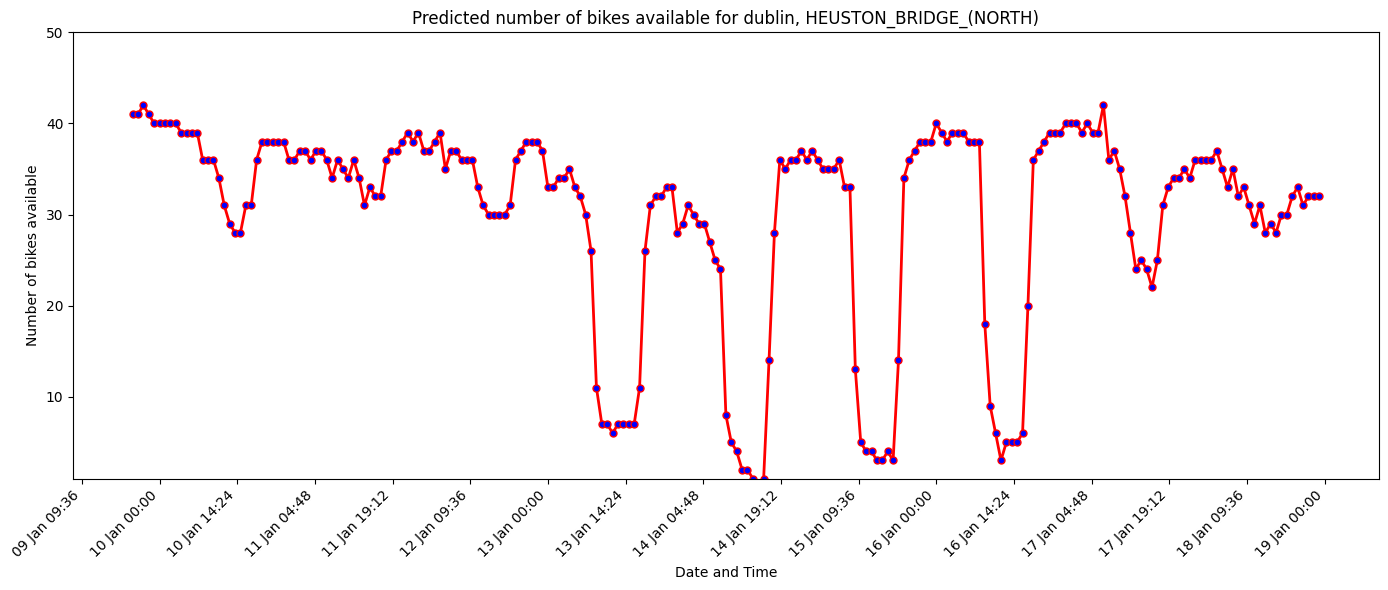

In [12]:
file_path = "docs/bike_availability_forecast.png"
plt = utils.plot_bike_availability_forecast(CITY, STATION, batch_data, file_path)
plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='bike_availability_predictions',
    description='Bike availability prediction monitoring for ' + STATION.replace("_", " "),
    version=1,
    primary_key=["datetime", "city"],
    event_time="datetime"
)

In [14]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |                                     | Rows 0/221 | Elapsed Time: 00:00 | Remaining Time: ?

Uploading Dataframe: 23.08% |███████▏                       | Rows 51/221 | Elapsed Time: 00:01 | Remaining Time: 00:03

Uploading Dataframe: 100.00% |█████████████████████████████| Rows 221/221 | Elapsed Time: 00:01 | Remaining Time: 00:00

Launching job: bike_availability_predictions_1_offline_fg_materialization


Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1207494/jobs/named/bike_availability_predictions_1_offline_fg_materialization/executions


2025-01-09 17:37:42,131 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED


2025-01-09 17:37:45,317 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


2025-01-09 17:39:18,002 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED


2025-01-09 17:39:18,220 INFO: Waiting for log aggregation to finish.


2025-01-09 17:39:40,628 INFO: Execution finished successfully.


(Job('bike_availability_predictions_1_offline_fg_materialization', 'SPARK'),
 None)

In [15]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.hours_before_forecast_time <= 24).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.17s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
0,2025-01-10 13:00:00+00:00,5.2000,0.734894,0.0,0.0,14.336861,28276.632812,0.0,dublin,1,4,13,29,19
1,2025-01-08 20:00:00+00:00,-1.0000,-5.029679,0.0,0.0,10.948973,28021.865234,0.0,dublin,1,2,20,40,2
2,2025-01-10 08:00:00+00:00,2.2500,-1.601857,0.0,0.0,10.630672,28276.632812,0.0,dublin,1,4,8,36,14
3,2025-01-09 22:00:00+00:00,-3.3000,-6.897349,0.0,0.0,6.034700,28145.916016,0.0,dublin,1,3,22,41,4
4,2025-01-09 17:00:00+00:00,-0.3000,-4.090576,0.0,0.0,10.105681,28145.916016,0.0,dublin,1,3,17,18,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2024-12-29 12:00:00+00:00,10.0895,6.403931,0.0,0.0,21.675617,27249.105469,0.0,dublin,12,6,12,30,21
68,2024-12-29 00:00:00+00:00,7.9395,5.065456,0.0,0.0,13.619471,27249.105469,0.0,dublin,12,6,0,35,9
69,2024-12-28 17:00:00+00:00,8.7895,5.991804,0.0,0.0,15.070633,27194.826172,0.0,dublin,12,5,17,31,2
70,2024-12-29 05:00:00+00:00,6.4395,2.621438,0.0,0.0,18.329973,27249.105469,0.0,dublin,12,6,5,35,14


In [16]:
bike_fg = fs.get_feature_group(
    name='bike_data',
    version=1,
)
bike_df = bike_fg.read()
bike_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.13s) 


,datetime,station,num_bikes_available
0,2024-09-23 10:00:00+00:00,HEUSTON_BRIDGE_(NORTH),2.0
1,2023-10-07 13:00:00+00:00,HEUSTON_BRIDGE_(NORTH),29.0
2,2023-11-27 07:00:00+00:00,HEUSTON_BRIDGE_(NORTH),34.0
3,2024-01-22 22:00:00+00:00,HEUSTON_BRIDGE_(NORTH),35.0
4,2023-10-16 02:00:00+00:00,HEUSTON_BRIDGE_(NORTH),40.0
...,...,...,...
9283,2025-01-08 22:48:55+00:00,HEUSTON_BRIDGE_(NORTH),40.0
9284,2025-01-08 15:49:13+00:00,HEUSTON_BRIDGE_(NORTH),40.0
9285,2025-01-08 21:49:15+00:00,HEUSTON_BRIDGE_(NORTH),40.0
9286,2025-01-08 23:49:15+00:00,HEUSTON_BRIDGE_(NORTH),40.0


In [17]:
weather_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.03s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city
0,2024-11-17 07:00:00+00:00,6.6395,3.542508,0.0,0.0,13.091829,30647.093750,2.6,dublin
1,2024-07-26 02:00:00+00:00,12.0395,9.959105,0.0,0.0,15.349684,57427.019531,0.9,dublin
2,2024-08-02 09:00:00+00:00,18.9895,18.108223,0.0,0.0,19.469975,56053.718750,2.5,dublin
3,2024-03-28 18:00:00+00:00,8.1395,6.004910,0.1,0.0,4.334974,46005.636719,1.3,dublin
4,2024-01-09 08:00:00+00:00,3.7895,-1.855704,0.0,0.0,21.602999,28177.490234,0.0,dublin
...,...,...,...,...,...,...,...,...,...
12715,2025-01-18 10:00:00+00:00,10.7000,7.080313,0.0,0.0,21.120682,29524.685547,0.0,dublin
12716,2025-01-18 22:00:00+00:00,7.7000,4.545562,0.0,0.0,13.276144,29524.685547,0.0,dublin
12717,2025-01-18 13:00:00+00:00,11.2000,7.610407,0.0,0.0,22.406927,29524.685547,0.0,dublin
12718,2025-01-18 01:00:00+00:00,7.0000,3.777550,0.0,0.0,13.009903,29524.685547,0.0,dublin


In [18]:
def backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, model):
    features_df = weather_fg.read()

    features_df["month"] = features_df["datetime"].dt.month
    features_df["weekday"] = features_df["datetime"].dt.weekday  # 0=Monday, 6=Sunday
    features_df["hour"] = features_df["datetime"].dt.hour

    features_df = pd.merge(features_df, bike_df[['datetime','num_bikes_available']], on="datetime")
    features_df = features_df.sort_values(by=['datetime'], ascending=True)
    features_df = features_df.tail(10*24)
    
    features_df['predicted_bikes_available'] = model.predict(features_df[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']])
    features_df['predicted_bikes_available'] = features_df['predicted_bikes_available'].apply(lambda x: round(x))

    features_df['hours_before_forecast_time'] = range(1, len(features_df) + 1)
    hindcast_df = features_df
    features_df = features_df.drop('num_bikes_available', axis=1)
    monitor_fg.insert(features_df, write_options={"wait_for_job": True})
    return hindcast_df

In [19]:
outcome_df = bike_df[['datetime', 'num_bikes_available']]
preds_df =  monitoring_df[['datetime', 'predicted_bikes_available']]

hindcast_df = pd.merge(preds_df, outcome_df, on="datetime")
hindcast_df = hindcast_df.sort_values(by=['datetime'])
print(len(hindcast_df))
hindcast_df

24


,datetime,predicted_bikes_available,num_bikes_available
12,2024-12-28 16:00:00+00:00,32,34.0
21,2024-12-28 17:00:00+00:00,31,33.0
6,2024-12-28 18:00:00+00:00,32,34.0
17,2024-12-28 19:00:00+00:00,32,33.0
7,2024-12-28 20:00:00+00:00,32,34.0
10,2024-12-28 21:00:00+00:00,36,34.0
16,2024-12-28 22:00:00+00:00,34,34.0
4,2024-12-28 23:00:00+00:00,34,35.0
20,2024-12-29 00:00:00+00:00,35,35.0
2,2024-12-29 01:00:00+00:00,35,35.0


In [20]:

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,datetime,predicted_bikes_available,num_bikes_available
12,2024-12-28 16:00:00+00:00,32,34.0
21,2024-12-28 17:00:00+00:00,31,33.0
6,2024-12-28 18:00:00+00:00,32,34.0
17,2024-12-28 19:00:00+00:00,32,33.0
7,2024-12-28 20:00:00+00:00,32,34.0
10,2024-12-28 21:00:00+00:00,36,34.0
16,2024-12-28 22:00:00+00:00,34,34.0
4,2024-12-28 23:00:00+00:00,34,35.0
20,2024-12-29 00:00:00+00:00,35,35.0
2,2024-12-29 01:00:00+00:00,35,35.0


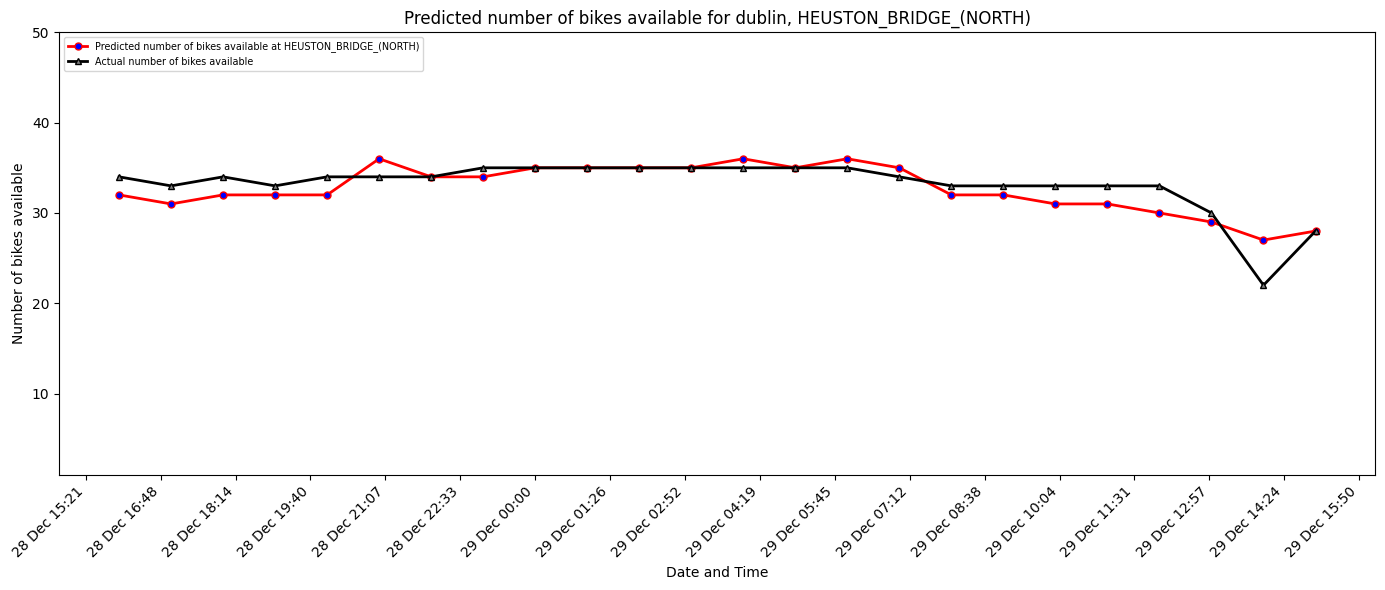

In [21]:
file_path = "docs/bike_availability_hindcast_1day.png"
plt = utils.plot_bike_availability_forecast(CITY, STATION, hindcast_df, file_path, hindcast=True)
plt.show()